Detected 23 out of 53 events (43.4%).
Saved 53 event records to /home/hajjohn1/bachelors-thesis/Results/events/eval_event_detection_mbkm_lag2_run_20250802_094226.json


/tmp/ipykernel_418725/1296429474.py:76: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_events.groupby('length_bin')['detected']


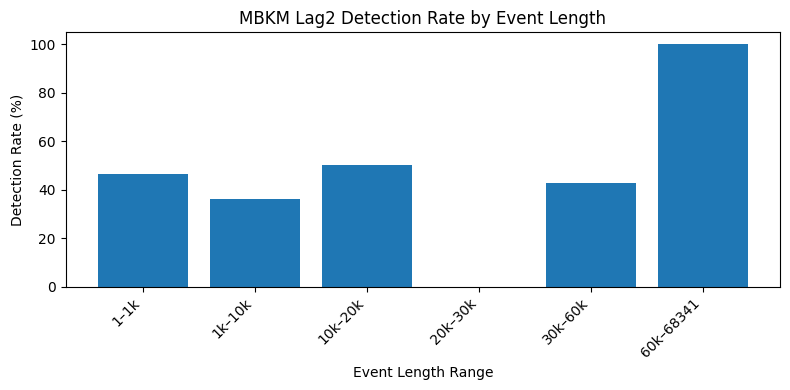

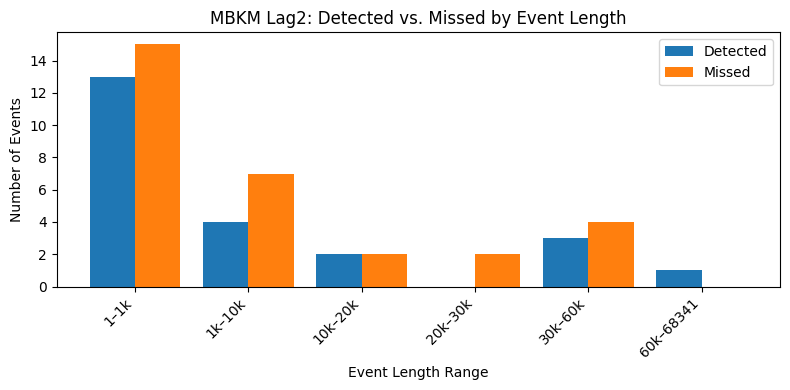

In [ ]:
import pandas as pd
import numpy as np
import json
from pathlib import Path
import joblib
import matplotlib.pyplot as plt

# Paths
BASE_DIR       = Path("/home/hajjohn1/bachelors-thesis")
EVAL_PATH      = BASE_DIR / "data" / "eval_lag.parquet"
RUN_DIR        = BASE_DIR / "Results" / "MBKM" / "lag2_r" / "run_20250802_094226"
MODEL_PATH     = RUN_DIR / "mbkmeans_model.pkl"
SCALER_PATH    = RUN_DIR / "scaler.pkl"
FEATURES_PATH  = RUN_DIR / "features.json"
THRESHOLD_PATH = RUN_DIR / "threshold.json"
OUTPUT_DIR     = BASE_DIR / "Results" / "events"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Load
with open(FEATURES_PATH, 'r') as f:
    features = json.load(f)
model  = joblib.load(MODEL_PATH)
scaler = joblib.load(SCALER_PATH)
with open(THRESHOLD_PATH, 'r') as f:
    threshold = json.load(f)["threshold_value"]

eval_df    = pd.read_parquet(EVAL_PATH)
X_eval_raw = eval_df[features].values.astype(np.float32)
X_eval     = scaler.transform(X_eval_raw)

# Compute distances and predictions
cluster_ids = model.predict(X_eval)
centers     = model.cluster_centers_
dists       = np.linalg.norm(X_eval - centers[cluster_ids], axis=1)
preds       = (dists >= threshold).astype(int)

# Identify anomaly events
mask        = eval_df['is_anomaly'] == 1
event_start = mask & (~mask.shift(fill_value=False))
event_ids   = event_start.cumsum()
eval_df['event_id'] = np.where(mask, event_ids, np.nan)

# Build and summarize event records
events = []
for eid, grp in eval_df[mask].groupby('event_id'):
    length   = int(len(grp))
    detected = bool(preds[grp.index].sum() > 0)
    events.append({'event_id': int(eid), 'length': length, 'detected': detected})

total = len(events)
detected_count = sum(e['detected'] for e in events)
print(f"Detected {detected_count} out of {total} events ({detected_count/total*100:.1f}%).")

# Save JSON
run_id = RUN_DIR.name
out_path = OUTPUT_DIR / f"eval_event_detection_mbkm_lag2_{run_id}.json"
with open(out_path, 'w') as f:
    json.dump({'model': run_id, 'threshold': threshold, 'events': events}, f, indent=2)
print(f"Saved {total} event records to {out_path}")

# Visaulization
df_events = pd.DataFrame(events)[['length','detected']]

# Define bins and labels
max_len = df_events['length'].max()
bins    = [1,1_000,10_000,20_000,30_000,60_000,max_len+1]
labels  = ["1–1k","1k–10k","10k–20k","20k–30k","30k–60k",f"60k–{int(max_len)}"]

df_events['length_bin'] = pd.cut(
    df_events['length'], bins=bins, labels=labels,
    right=False, include_lowest=True
)

grouped = (
    df_events.groupby('length_bin')['detected']
             .agg(total_events='count', detected_events='sum')
)
grouped['detection_rate'] = grouped['detected_events'] / grouped['total_events'] * 100

# Plot detection rate
plt.figure(figsize=(8,4))
plt.bar(grouped.index, grouped['detection_rate'])
plt.xlabel('Event Length Range')
plt.ylabel('Detection Rate (%)')
plt.title('MBKM Lag2 Detection Rate by Event Length')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot counts detected vs. missed
undetected = grouped['total_events'] - grouped['detected_events']
x = np.arange(len(grouped.index))
width = 0.4

plt.figure(figsize=(8,4))
plt.bar(x-width/2, grouped['detected_events'], width, label='Detected')
plt.bar(x+width/2, undetected,         width, label='Missed')
plt.xticks(x, grouped.index, rotation=45, ha='right')
plt.xlabel('Event Length Range')
plt.ylabel('Number of Events')
plt.title('MBKM Lag2: Detected vs. Missed by Event Length')
plt.legend()
plt.tight_layout()
plt.show()


In [2]:
total_events = len(events)
detected_count = sum(e['detected'] for e in events)
print(f"Detected {detected_count} out of {total_events} events ({detected_count/total_events*100:.1f}%).")


Detected 23 out of 53 events (43.4%).
